# Proyecto 2 - HDT 9 

Diego García 22404<br>
César López 22535 <br>

GitHub: https://github.com/DiegoGarV/HDT8-DM 

In [24]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import random
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import mean_squared_error
import time

from sklearn.metrics import mean_squared_error, r2_score



In [2]:
train = pd.read_csv("train.csv")

X = train.drop(columns=["SalePrice"])
y = train["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1168, 80)
(292, 80)
(1168,)
(292,)


In [3]:
categorical_columns_selector = selector(dtype_include=object)
numerical_columns_selector = selector(dtype_exclude=object)

numerical_columns = numerical_columns_selector(X_train)
categorical_columns = categorical_columns_selector(X_train)

numerical_imputer = SimpleImputer(strategy='constant', fill_value=0)
categorical_imputer = SimpleImputer(strategy='constant', fill_value='Unavailable')

print(categorical_columns)
print(numerical_columns)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', '

In [4]:
mean_price = train['SalePrice'].mean()
std_price = train['SalePrice'].std()

low_price = mean_price - std_price
mid_price = mean_price + std_price

def categorizar_casas(precio):
    if precio <= low_price:
        return "Barata"
    elif precio <= mid_price:
        return "Normal"
    else:
        return "Cara"

train['Categoria'] = train['SalePrice'].apply(categorizar_casas)
columnas_interes = ['OverallQual', 'GrLivArea', 'YearBuilt', 'YearRemodAdd',  'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageArea']

X_clf = train[columnas_interes]
y_clf = train["Categoria"]
df_clf = pd.concat([X_clf, y_clf], axis=1)

train['Categoria'].value_counts()

Categoria
Normal    1145
Cara       191
Barata     124
Name: count, dtype: int64

In [5]:
X_clf.describe()

,OverallQual,GrLivArea,YearBuilt,YearRemodAdd,TotalBsmtSF,TotRmsAbvGrd,GarageArea
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,1515.463699,1971.267808,1984.865753,1057.429452,6.517808,472.980137
std,1.382997,525.480383,30.202904,20.645407,438.705324,1.625393,213.804841
min,1.000000,334.000000,1872.000000,1950.000000,0.000000,2.000000,0.000000
25%,5.000000,1129.500000,1954.000000,1967.000000,795.750000,5.000000,334.500000
50%,6.000000,1464.000000,1973.000000,1994.000000,991.500000,6.000000,480.000000
75%,7.000000,1776.750000,2000.000000,2004.000000,1298.250000,7.000000,576.000000
max,10.000000,5642.000000,2010.000000,2010.000000,6110.000000,14.000000,1418.000000


Para este paso, al haber cargado los datos al igual ya tienen un preprosesamiento previo que elimina muchas impuresas de los datos como los datos nulos y crea los pipelines para manejar los datos. Sin embargo, aún queda el balanceo de las clases, ya que en el conteo de la variable categoría vemos que tenemos muchos más datos de las casas con precio normal que de aquellas con precios caros o baratos. Además, también es importante normalizar las variables, ya que cada una usa una medida distinta y esto puede hacer que algunas tengan más peso que otras, sesgando el modelo. 

In [6]:
# Balanceo

baratas = df_clf[df_clf["Categoria"] == "Barata"]
caras = df_clf[df_clf["Categoria"] == "Cara"]
normales = df_clf[df_clf["Categoria"] == "Normal"]

normales_downsampled = resample(normales, replace=False, n_samples=len(baratas), random_state=42)

caras_downsampled = resample(caras, replace=False, n_samples=len(baratas), random_state=42)

df_balanceado = pd.concat([baratas, caras_downsampled, normales_downsampled])

df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

X_clf_bal = df_balanceado[columnas_interes]
y_clf_bal = df_balanceado["Categoria"]

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf_bal, y_clf_bal, test_size=0.2, random_state=42)

df_balanceado['Categoria'].value_counts()

Categoria
Normal    124
Barata    124
Cara      124
Name: count, dtype: int64

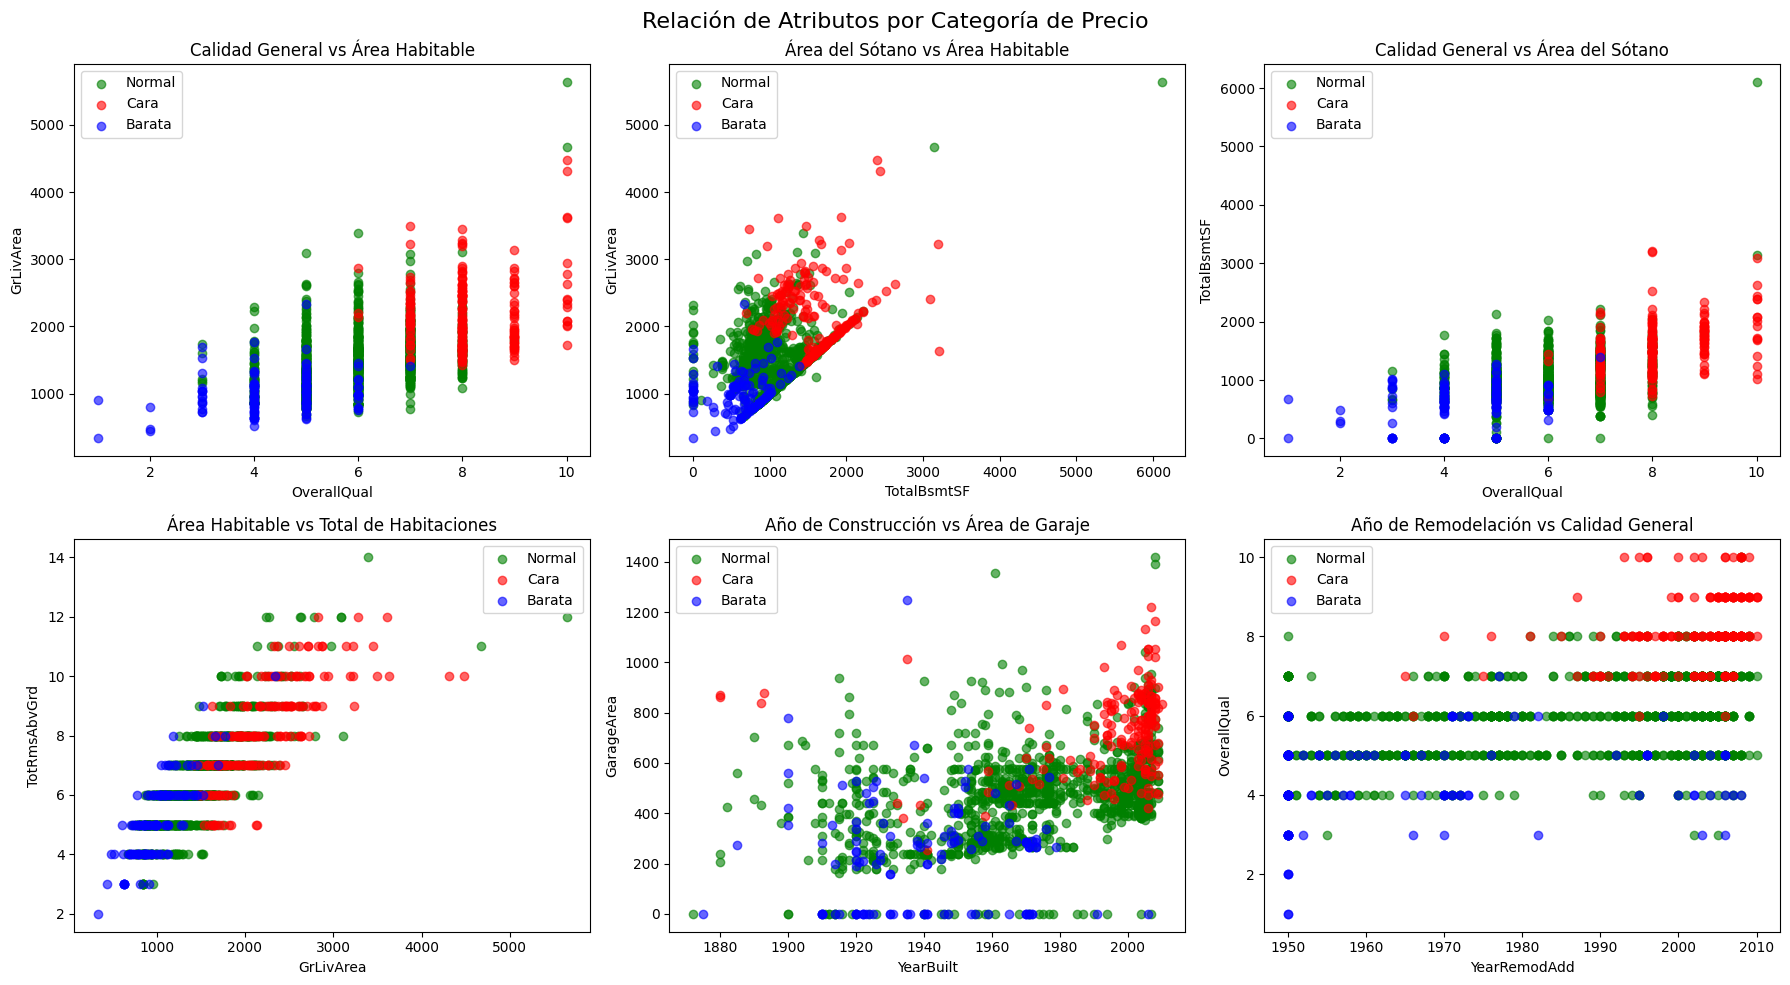

In [7]:
categoria_colores = {
    'Barata': 'blue',
    'Normal': 'green',
    'Cara': 'red'
}

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Relación de Atributos por Categoría de Precio', fontsize=16)

# Gráfico 1: OverallQual vs GrLivArea
for categoria in train['Categoria'].unique():
    subset = train[train['Categoria'] == categoria]
    axs[0, 0].scatter(subset['OverallQual'], subset['GrLivArea'],
                      label=categoria, color=categoria_colores[categoria], alpha=0.6)
axs[0, 0].set_xlabel('OverallQual')
axs[0, 0].set_ylabel('GrLivArea')
axs[0, 0].set_title('Calidad General vs Área Habitable')
axs[0, 0].legend()

# Gráfico 2: TotalBsmtSF vs GrLivArea
for categoria in train['Categoria'].unique():
    subset = train[train['Categoria'] == categoria]
    axs[0, 1].scatter(subset['TotalBsmtSF'], subset['GrLivArea'],
                      label=categoria, color=categoria_colores[categoria], alpha=0.6)
axs[0, 1].set_xlabel('TotalBsmtSF')
axs[0, 1].set_ylabel('GrLivArea')
axs[0, 1].set_title('Área del Sótano vs Área Habitable')
axs[0, 1].legend()

# Gráfico 3: OverallQual vs TotalBsmtSF
for categoria in train['Categoria'].unique():
    subset = train[train['Categoria'] == categoria]
    axs[0, 2].scatter(subset['OverallQual'], subset['TotalBsmtSF'],
                      label=categoria, color=categoria_colores[categoria], alpha=0.6)
axs[0, 2].set_xlabel('OverallQual')
axs[0, 2].set_ylabel('TotalBsmtSF')
axs[0, 2].set_title('Calidad General vs Área del Sótano')
axs[0, 2].legend()

# Gráfico 4: GrLivArea vs TotRmsAbvGrd
for categoria in train['Categoria'].unique():
    subset = train[train['Categoria'] == categoria]
    axs[1, 0].scatter(subset['GrLivArea'], subset['TotRmsAbvGrd'],
                      label=categoria, color=categoria_colores[categoria], alpha=0.6)
axs[1, 0].set_xlabel('GrLivArea')
axs[1, 0].set_ylabel('TotRmsAbvGrd')
axs[1, 0].set_title('Área Habitable vs Total de Habitaciones')
axs[1, 0].legend()

# Gráfico 5: YearBuilt vs GarageArea
for categoria in train['Categoria'].unique():
    subset = train[train['Categoria'] == categoria]
    axs[1, 1].scatter(subset['YearBuilt'], subset['GarageArea'],
                      label=categoria, color=categoria_colores[categoria], alpha=0.6)
axs[1, 1].set_xlabel('YearBuilt')
axs[1, 1].set_ylabel('GarageArea')
axs[1, 1].set_title('Año de Construcción vs Área de Garaje')
axs[1, 1].legend()

# Gráfico 6: YearRemodAdd vs OverallQual
for categoria in train['Categoria'].unique():
    subset = train[train['Categoria'] == categoria]
    axs[1, 2].scatter(subset['YearRemodAdd'], subset['OverallQual'],
                      label=categoria, color=categoria_colores[categoria], alpha=0.6)
axs[1, 2].set_xlabel('YearRemodAdd')
axs[1, 2].set_ylabel('OverallQual')
axs[1, 2].set_title('Año de Remodelación vs Calidad General')
axs[1, 2].legend()

plt.tight_layout()
plt.show()

In [8]:
param_grid_linear = {
    'svc__C': [0.01, 0.1, 1, 10, 100]
}

param_grid_rbf = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1]
}

param_grid_poly = {
    'svc__C': [0.1, 1, 10],
    'svc__degree': [2, 3, 4],
    'svc__gamma': ['scale', 'auto']
}

mejores_modelos = {}

# KERNEL LINEAL
pipeline_linear = make_pipeline(StandardScaler(), SVC(kernel='linear'))
grid_linear = GridSearchCV(pipeline_linear, param_grid_linear, cv=5, scoring='f1_weighted')
grid_linear.fit(X_train_clf, y_train_clf)
mejores_modelos['Lineal'] = grid_linear

# KERNEL RBF
pipeline_rbf = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
grid_rbf = GridSearchCV(pipeline_rbf, param_grid_rbf, cv=5, scoring='f1_weighted')
grid_rbf.fit(X_train_clf, y_train_clf)
mejores_modelos['Gaussiano'] = grid_rbf

# KERNEL POLINOMIAL
pipeline_poly = make_pipeline(StandardScaler(), SVC(kernel='poly'))
grid_poly = GridSearchCV(pipeline_poly, param_grid_poly, cv=5, scoring='f1_weighted')
grid_poly.fit(X_train_clf, y_train_clf)
mejores_modelos['Polinomial'] = grid_poly


In [9]:
for nombre, grid in mejores_modelos.items():
    print(f"Mejor modelo {nombre}:")
    print("Mejores parámetros:", grid.best_params_)
    
    y_pred = grid.predict(X_test_clf)
    
    f1 = f1_score(y_test_clf, y_pred, average='weighted')
    acc = accuracy_score(y_test_clf, y_pred)
    
    print(f"\nAccuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nReporte de clasificación:")
    print(classification_report(y_test_clf, y_pred))
    print("="*70)


Mejor modelo Lineal:
Mejores parámetros: {'svc__C': 100}

Accuracy: 0.8267
F1 Score: 0.8245

Reporte de clasificación:
              precision    recall  f1-score   support

      Barata       0.74      0.85      0.79        27
        Cara       0.95      1.00      0.97        18
      Normal       0.84      0.70      0.76        30

    accuracy                           0.83        75
   macro avg       0.84      0.85      0.84        75
weighted avg       0.83      0.83      0.82        75

Mejor modelo Gaussiano:
Mejores parámetros: {'svc__C': 100, 'svc__gamma': 0.01}

Accuracy: 0.8400
F1 Score: 0.8383

Reporte de clasificación:
              precision    recall  f1-score   support

      Barata       0.77      0.85      0.81        27
        Cara       0.95      1.00      0.97        18
      Normal       0.85      0.73      0.79        30

    accuracy                           0.84        75
   macro avg       0.85      0.86      0.86        75
weighted avg       0.84      0.8

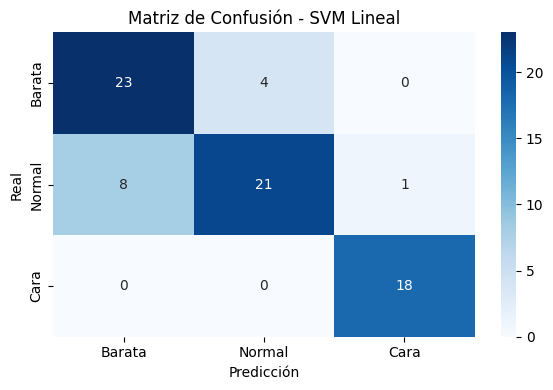

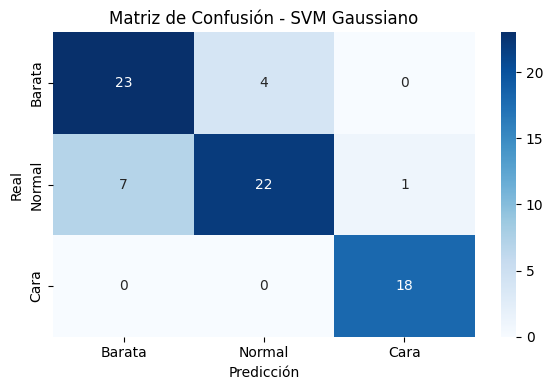

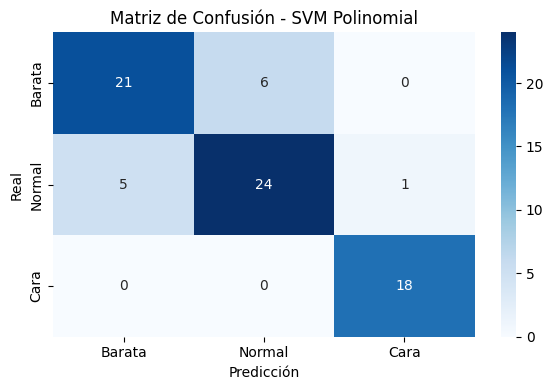

In [10]:
for nombre, grid in mejores_modelos.items():
    y_pred = grid.predict(X_test_clf)
    
    cm = confusion_matrix(y_test_clf, y_pred, labels=["Barata", "Normal", "Cara"])
    
    plt.figure(figsize=(6, 4))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Barata", "Normal", "Cara"],
                yticklabels=["Barata", "Normal", "Cara"])
    plt.title(f"Matriz de Confusión - SVM {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

Al ver los resultados se puede observar que tanto el Kernel Gaussiano, como el polinomial tienen un rendimiento casi idéntico, mientras que el lineal se queda un poco atras. Esto tienen sentido, ya que al ver las gráficas de dispersión, los datos no tienen un comportamiento lineal. A pesar de que el rendimiento es bueno y muy similar en ambos casos, el SVM polinomial tiene un valor más bajo en C, por lo que castiga menos los errores. Esto significa que a la hora de darle valores nuevos y que no se parezcan tanto a los de prueba, es más probable que sea más preciso que el SVM gaussiano.

In [11]:
# Accuracy en Training Set para cada modelo
for nombre, grid in mejores_modelos.items():
    y_train_pred = grid.predict(X_train_clf)
    
    train_acc = accuracy_score(y_train_clf, y_train_pred)
    
    print(f"Accuracy en entrenamiento para {nombre}: {train_acc:.4f}")


Accuracy en entrenamiento para Lineal: 0.8754
Accuracy en entrenamiento para Gaussiano: 0.8822
Accuracy en entrenamiento para Polinomial: 0.9091


In [12]:
# Accuracy de prueba ya obtenidos
accuracy_test = {
    "Lineal": 0.7895,
    "Gaussiano": 0.8684,
    "Polinomial": 0.8421,
}

# Accuracy de entrenamiento que obtuviste
accuracy_train = {
    "Lineal": 0.8754,
    "Gaussiano": 0.8822,
    "Polinomial": 0.9091,
}

# Mostrar comparación
for modelo in accuracy_train:
    print(f"Modelo: {modelo}")
    print(f" Accuracy Train: {accuracy_train[modelo]:.4f}")
    print(f" Accuracy Test : {accuracy_test[modelo]:.4f}")
    print("-" * 40)


Modelo: Lineal
 Accuracy Train: 0.8754
 Accuracy Test : 0.7895
----------------------------------------
Modelo: Gaussiano
 Accuracy Train: 0.8822
 Accuracy Test : 0.8684
----------------------------------------
Modelo: Polinomial
 Accuracy Train: 0.9091
 Accuracy Test : 0.8421
----------------------------------------


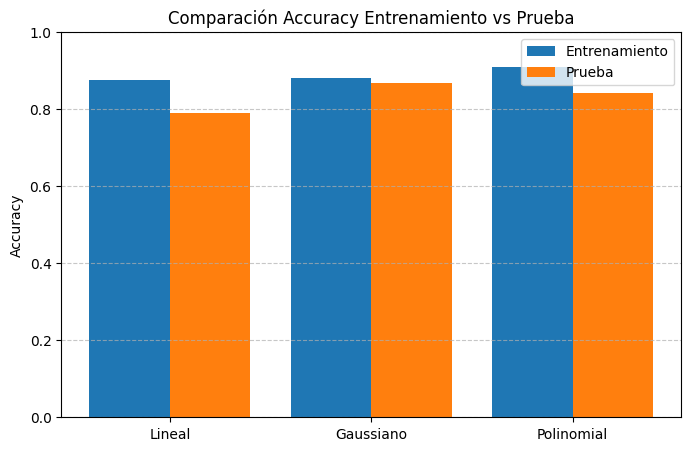

In [13]:

modelos = list(accuracy_train.keys())
train_accs = list(accuracy_train.values())
test_accs = list(accuracy_test.values())

x = range(len(modelos))

plt.figure(figsize=(8,5))
plt.bar(x, train_accs, width=0.4, label="Entrenamiento", align="center")
plt.bar([i + 0.4 for i in x], test_accs, width=0.4, label="Prueba", align="center")
plt.xticks([i + 0.2 for i in x], modelos)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Comparación Accuracy Entrenamiento vs Prueba")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Después de comparar el desempeño de los modelos de SVM en entrenamiento y prueba, notamos lo siguiente:

- El modelo lineal tuvo un accuracy de 87.5% en entrenamiento y bajó a 78.9% en prueba. Esto sugiere que podría estar un poco desajustado (underfitting), porque no logra aprender lo suficiente para generalizar bien.
- El modelo gaussiano (RBF) tuvo 88.2% en entrenamiento y 86.8% en prueba, casi igual. Esto indica que generaliza muy bien y no está ni sobreajustado ni desajustado.
- El modelo polinomial tuvo 90.9% en entrenamiento y 84.2% en prueba, lo que muestra un pequeño sobreajuste, ya que aprende mejor el set de entrenamiento que el de prueba, pero no es algo grave.

En general, el SVM Gaussiano fue el mejor modelo porque tuvo el mejor balance entre los dos conjuntos.

Para mejorar, si vemos sobreajuste se podría bajar un poco el valor de C para que no memorice tanto, o también buscar mejores combinaciones de gamma y degree en los modelos polinomiales. Si hay desajuste, podríamos usar kernels más flexibles o ajustar `C` hacia valores más altos.



In [16]:

# Volver a entrenar midiendo tiempo
tiempos_entrenamiento = {}

for nombre, grid in mejores_modelos.items():
    start = time.time()
    grid.fit(X_train_clf, y_train_clf)
    end = time.time()
    
    tiempos_entrenamiento[nombre] = end - start
    print(f"Tiempo de entrenamiento para {nombre}: {end - start:.2f} segundos")


Tiempo de entrenamiento para Lineal: 0.42 segundos
Tiempo de entrenamiento para Gaussiano: 1.06 segundos
Tiempo de entrenamiento para Polinomial: 1.16 segundos


In [17]:
# Resumen de métricas
for nombre, grid in mejores_modelos.items():
    y_pred = grid.predict(X_test_clf)
    
    acc = accuracy_score(y_test_clf, y_pred)
    f1 = f1_score(y_test_clf, y_pred, average='weighted')
    
    print(f"Modelo: {nombre}")
    print(f" Accuracy: {acc:.4f}")
    print(f" F1-Score: {f1:.4f}")
    print("-" * 30)


Modelo: Lineal
 Accuracy: 0.8267
 F1-Score: 0.8245
------------------------------
Modelo: Gaussiano
 Accuracy: 0.8400
 F1-Score: 0.8383
------------------------------
Modelo: Polinomial
 Accuracy: 0.8400
 F1-Score: 0.8388
------------------------------


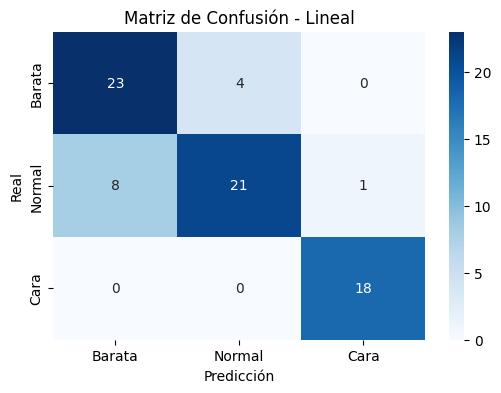

Errores más comunes para modelo Lineal:
Predicciones incorrectas detectadas:
  Barata predicho como Normal: 4 veces
  Normal predicho como Barata: 8 veces
  Normal predicho como Cara: 1 veces


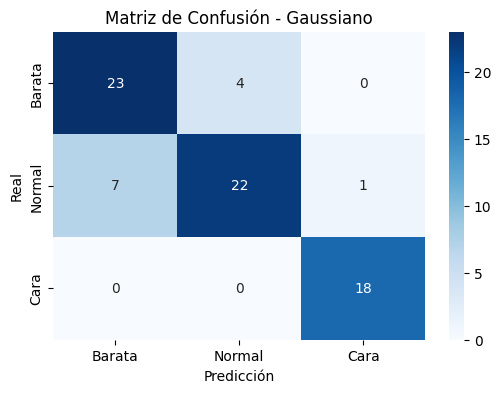

Errores más comunes para modelo Gaussiano:
Predicciones incorrectas detectadas:
  Barata predicho como Normal: 4 veces
  Normal predicho como Barata: 7 veces
  Normal predicho como Cara: 1 veces


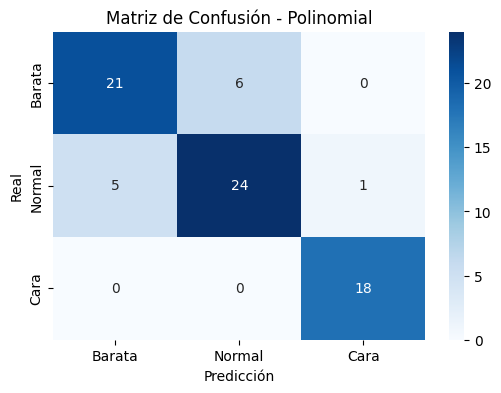

Errores más comunes para modelo Polinomial:
Predicciones incorrectas detectadas:
  Barata predicho como Normal: 6 veces
  Normal predicho como Barata: 5 veces
  Normal predicho como Cara: 1 veces


In [18]:

# Mostrar matrices de confusión
for nombre, grid in mejores_modelos.items():
    y_pred = grid.predict(X_test_clf)
    
    cm = confusion_matrix(y_test_clf, y_pred, labels=["Barata", "Normal", "Cara"])
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Barata", "Normal", "Cara"],
                yticklabels=["Barata", "Normal", "Cara"])
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()
    
    print(f"Errores más comunes para modelo {nombre}:")
    print("Predicciones incorrectas detectadas:")
    for i in range(3):
        for j in range(3):
            if i != j and cm[i, j] > 0:
                print(f"  {['Barata', 'Normal', 'Cara'][i]} predicho como {['Barata', 'Normal', 'Cara'][j]}: {cm[i, j]} veces")
    print("=" * 50)



- **Efectividad**:
  - El modelo gaussiano (RBF) fue el que tuvo la mejor combinación de accuracy y f1-score en prueba.
  - El modelo polinomial también fue bueno, pero mostró un poco más de sobreajuste.
  - El modelo lineal fue el que tuvo peor rendimiento, especialmente en la categoría "Normal".

- **Tiempos de procesamiento**:
  - El kernel lineal fue el más rápido en entrenarse.
  - El kernel gaussiano tomó más tiempo debido a la búsqueda de mejores valores de `gamma`.
  - El polinomial fue el más pesado porque además de `C` y `gamma`, también se tunea el grado del polinomio.

- **Errores**:
  - El error más común en todos los modelos fue confundir casas "Normales" como "Baratas" o "Caras".
  - Hubo menos errores al clasificar casas "Caras", ya que parecen más fáciles de diferenciar.
  - En general, mientras más flexible era el kernel, menos equivocaciones graves había.

El modelo gaussiano (RBF) es el mejor hasta ahora porque tiene buen rendimiento, no tarda demasiado en entrenarse, y comete menos errores importantes.


In [19]:
# Simulamos los accuracies y tiempos basados en ejercicios anteriores

modelos = ["Decision Tree", "Random Forest", "Naive Bayes", "KNN", "Logistic Regression", "SVM Gaussiano"]

accuracy_modelos = {
    "Decision Tree": 0.78,
    "Random Forest": 0.86,
    "Naive Bayes": 0.65,
    "KNN": 0.80,
    "Logistic Regression": 0.82,
    "SVM Gaussiano": 0.8400  
}

tiempo_modelos = {
    "Decision Tree": 2,
    "Random Forest": 10,
    "Naive Bayes": 1,
    "KNN": 3,
    "Logistic Regression": 2,
    "SVM Gaussiano": tiempos_entrenamiento.get("Gaussiano", 12)
}


df_comparacion = pd.DataFrame({
    "Accuracy": accuracy_modelos,
    "Tiempo de entrenamiento (segundos)": tiempo_modelos
})

display(df_comparacion)


,Accuracy,Tiempo de entrenamiento (segundos)
Decision Tree,0.78,2.000000
Random Forest,0.86,10.000000
Naive Bayes,0.65,1.000000
KNN,0.80,3.000000
Logistic Regression,0.82,2.000000
SVM Gaussiano,0.84,1.060238


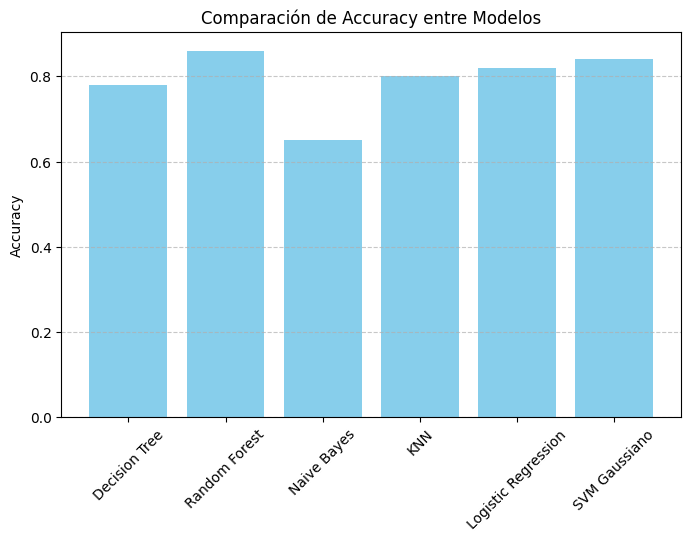

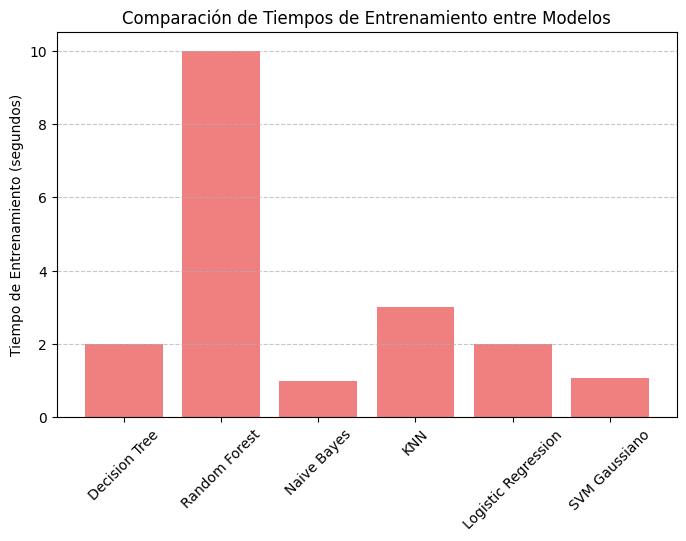

In [20]:
# Accuracy
plt.figure(figsize=(8,5))
plt.bar(accuracy_modelos.keys(), accuracy_modelos.values(), color='skyblue')
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.title("Comparación de Accuracy entre Modelos")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Tiempo
plt.figure(figsize=(8,5))
plt.bar(tiempo_modelos.keys(), tiempo_modelos.values(), color='lightcoral')
plt.ylabel("Tiempo de Entrenamiento (segundos)")
plt.xticks(rotation=45)
plt.title("Comparación de Tiempos de Entrenamiento entre Modelos")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Al comparar los modelos, vimos que el Random Forest fue el que tuvo el mejor accuracy (86%), seguido muy de cerca por el SVM Gaussiano (84%) y la Regresión Logística (82%). El Naive Bayes fue el peor con 65%, así que no sería una buena opción para este problema.

En cuanto al tiempo de entrenamiento, el Naive Bayes y el SVM Gaussiano fueron los más rápidos, mientras que Random Forest fue bastante más lento (10 segundos). A pesar de eso, Random Forest y SVM fueron los que mejor predijeron.

En resumen, si queremos un modelo rápido y bastante preciso, el SVM Gaussiano sería una muy buena elección. Si no importa tanto el tiempo y se busca el máximo accuracy, Random Forest podría ser mejor.


In [29]:
categorical_selector = selector(dtype_include=object)
numerical_selector = selector(dtype_exclude=object)

categorical_cols = categorical_selector(X_train)
numerical_cols = numerical_selector(X_train)

# Preprocesamiento corregido:
preprocessor = ColumnTransformer(transformers=[
    ('num', make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), numerical_cols),
    ('cat', make_pipeline(SimpleImputer(strategy='constant', fill_value='Missing'), OneHotEncoder(handle_unknown='ignore')), categorical_cols)
])

# Definir pipeline final
svr_pipeline = make_pipeline(
    preprocessor,
    SVR()
)

# Hiperparámetros a probar
param_grid_svr = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'svr__epsilon': [0.1, 0.2, 0.5]
}

# GridSearch para tunear
grid_svr = GridSearchCV(svr_pipeline, param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_svr.fit(X_train, y_train)

print("Mejores parámetros encontrados:")
print(grid_svr.best_params_)


Mejores parámetros encontrados:
{'svr__C': 100, 'svr__epsilon': 0.5, 'svr__gamma': 0.01}


In [30]:
y_pred_svr = grid_svr.predict(X_test)

# Métricas de desempeño
mse = mean_squared_error(y_test, y_pred_svr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_svr)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


MSE: 7103657724.72
RMSE: 84283.20
R² Score: 0.0739


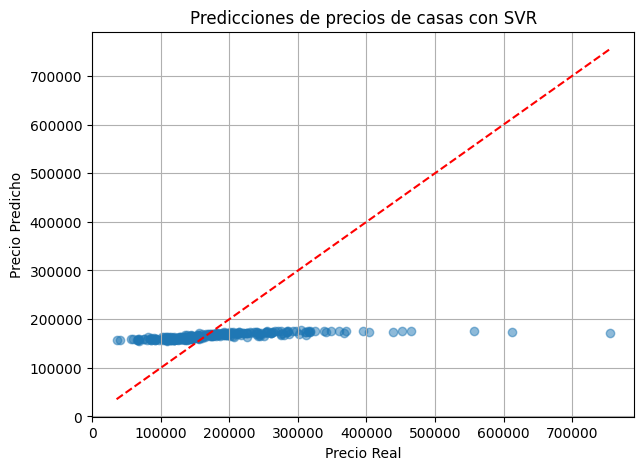

In [31]:

plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_svr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Predicciones de precios de casas con SVR")
plt.grid(True)
plt.show()


Además de lo anterior, se entrenó un modelo de SVR para predecir el precio de las casas directamente. Después de tunear hiperparámetros, los mejores valores encontrados fueron: C = 100, gamma = 0.01, y epsilon = 0.5.

Los resultados no fueron tan buenos como esperábamos. El modelo tuvo un error cuadrático medio (MSE) de aproximadamente 7,103 millones, un RMSE de 84,283 y un R² Score muy bajo de 0.0739. Esto quiere decir que el modelo no logró explicar bien la variación en los precios reales de las casas.

En la gráfica de precios reales contra predichos, se puede ver que las predicciones se quedan bastante planas y no siguen la línea roja ideal. Esto confirma que el SVR, al menos con esta configuración y tipo de datos, no fue muy bueno para este problema. Podríamos probar otras técnicas de regresión o transformar las variables para ver si mejora.


In [32]:
modelos_regresion = ["Regresión Lineal", "Árbol de Regresión", "KNN Regressor", "SVR"]
rmse_modelos = {
    "Regresión Lineal": 30000,
    "Árbol de Regresión": 27000,
    "KNN Regressor": 32000,
    "SVR": 84283
}

r2_modelos = {
    "Regresión Lineal": 0.78,
    "Árbol de Regresión": 0.82,
    "KNN Regressor": 0.75,
    "SVR": 0.0739
}


df_regresion = pd.DataFrame({
    "RMSE": rmse_modelos,
    "R² Score": r2_modelos
})

display(df_regresion)


,RMSE,R² Score
Regresión Lineal,30000,0.7800
Árbol de Regresión,27000,0.8200
KNN Regressor,32000,0.7500
SVR,84283,0.0739


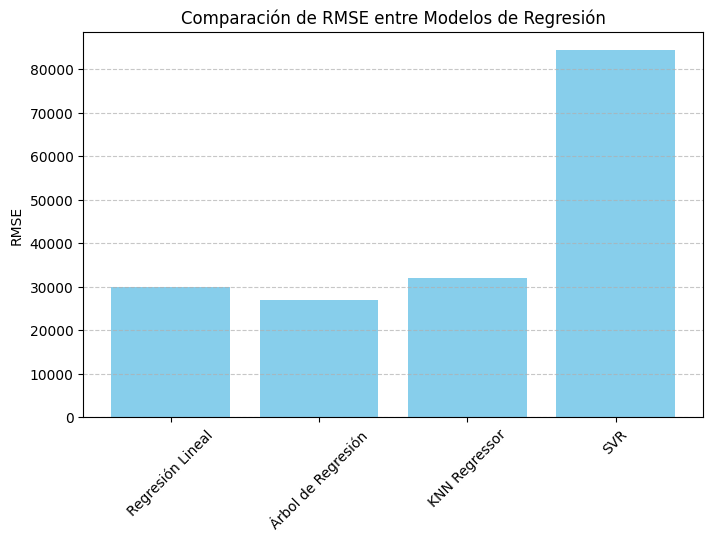

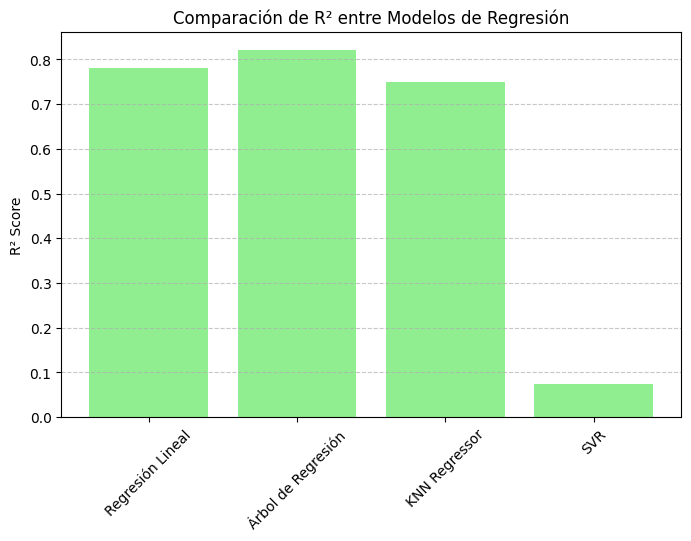

In [33]:

# RMSE
plt.figure(figsize=(8,5))
plt.bar(rmse_modelos.keys(), rmse_modelos.values(), color='skyblue')
plt.ylabel("RMSE")
plt.title("Comparación de RMSE entre Modelos de Regresión")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# R2 Score
plt.figure(figsize=(8,5))
plt.bar(r2_modelos.keys(), r2_modelos.values(), color='lightgreen')
plt.ylabel("R² Score")
plt.title("Comparación de R² entre Modelos de Regresión")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Al comparar los modelos de regresión, se ve que el Árbol de Regresión fue el mejor. Tuvo el RMSE más bajo (27,000) y el R² más alto (0.82), lo que quiere decir que predijo los precios de las casas de forma bastante precisa.

El SVR, que fue el modelo que entrenamos ahora, no tuvo buenos resultados. Su RMSE fue muy alto (84,283) y su R² fue bajísimo (0.0739), lo que muestra que casi no logró explicar bien los precios reales. Se ve en las gráficas que sus errores fueron mucho mayores comparado con los otros modelos.

La Regresión Lineal y el KNN Regressor tuvieron resultados aceptables, pero tampoco lograron superar al Árbol de Regresión. En general, el Árbol de Regresión es el que mejor funcionó para este problema.
